In [17]:
%load_ext autoreload
%autoreload 2

import sys, os
from Scripts import train_metric_learning, run_metric_learning_inference, train_gnn, run_gnn_inference, build_track_candidates, evaluate_candidates
import yaml

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device} available')
import pandas as pd, numpy as np

from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure, row
from bokeh.models import ColumnDataSource
from bokeh.palettes import viridis
from bokeh.models.annotations import Label

from Pipelines.Common_Tracking_Example.notebooks.ITk.Exploration.gnn_utils import infer_event
from Pipelines.TrackML_Example.notebooks.build_embedding import EmbeddingInferenceBuilder

from matplotlib import pyplot as plt

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
CONFIG = 'pipeline_config.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda available


Loading BokehJS ...

# 0. Download Data

In [ ]:
!mkdir datasets
!wget https://portal.nersc.gov/cfs/m3443/dtmurnane/TrackML_Example/trackml_quickstart_dataset.tar.gz -O datasets/trackml_quickstart_dataset.tar.gz

In [10]:
%%capture
!tar -xvf datasets/trackml_quickstart_dataset.tar.gz -C datasets;
!rm datasets/trackml_quickstart_dataset.tar.gz

### Pipeline configurations

The configurations for the entire pipeline are defined under pipeline_config.yml. 

In [18]:
with open(CONFIG, 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)

In [35]:
import sys
import os
import yaml
import argparse
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
import torch

sys.path.append("../../")
# sys.path.append('./')
from Pipelines.TrackML_Example.LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from utils import headline

from pytorch_lightning import Callback

class DeviceCallback(Callback):

    def on_batch_start(self, trainer, pl_module):
        print( next(pl_module.parameters()).device.type )

def train(config_file="pipeline_config.yaml"):

    logging.info(headline("Step 1: Running metric learning training"))

    with open(config_file) as file:
        all_configs = yaml.load(file, Loader=yaml.FullLoader)
    
    common_configs = all_configs["common_configs"]
    metric_learning_configs = all_configs["metric_learning_configs"]

    logging.info(headline("a) Initialising model"))

    model = LayerlessEmbedding(metric_learning_configs)
    
    model.to(device)

    logging.info(headline("b) Running training" ))

    save_directory = os.path.join(common_configs["artifact_directory"], "metric_learning")
    logger = CSVLogger(save_directory, name=common_configs["experiment_name"])

    trainer = Trainer(
        accelerator='gpu' if torch.cuda.is_available() else None,
        auto_select_gpus=True,
        gpus=1,
        max_epochs=common_configs["max_epochs"],
        logger=logger, 
        # callbacks=[DeviceCallback()]
    )

    logging.info(headline(f"Training model on {model.device}"))

    trainer.fit(model)
    
    logging.info(headline(f"Trained model on {model.device}"))

    logging.info(headline("c) Saving model") )

    os.makedirs(save_directory, exist_ok=True)
    trainer.save_checkpoint(os.path.join(save_directory, common_configs["experiment_name"]+".ckpt"))

    return trainer, model

# 1. Train Metric Learning

## What it does
Broadly speaking, the first stage of our pipeline is embedding the space points on to graphs, in a way that is efficient, i.e. we miss as few points on a graph as possible. We train a MLP to transform the input feature vector of each space point $\mathbf{u}_i$ into an N-dimensional latent space $\mathbf{v}_i$. The graph is then constructed by connecting the space points whose Euclidean distance between the latent space points $$d_{ij} = \left| \mathbf{v}_i - \mathbf{v}_j \right| < r_{embedding}$$

## Training data
Let us take a look at the data before training. In this example pipeline, we have preprocessed the TrackML data into a more convenient form. We calculated directional information and summary statistics from the charge deposited in each spacepoints, and append them to its cyclidrical coordinates. Let us load an example data file and inspect the content.

In [3]:
from Pipelines.TrackML_Example.LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding

metric_learning_configs = configs['metric_learning_configs']

model = LayerlessEmbedding(metric_learning_configs)
model.setup(stage='fit')
clear_output()

print(model.trainset[0])
example_data = model.get_input_data(model.trainset[0])
example_data_df = pd.DataFrame(example_data.numpy())
example_data_df.head()

Data(x=[12083, 3], pid=[12083], modules=[12083], event_file='/global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021045', hid=[12083], pt=[12083], weights=[10965], modulewise_true_edges=[2, 10965], layerwise_true_edges=[2, 14426], cell_data=[12083, 9], signal_true_edges=[2, 10965])


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.323412,2.091356,0.844154,0.05,0.05625,0.3,-2.091356,0.962261,0.051929,0.083736,-0.958000
1,6.0,0.308704,0.884925,1.229181,0.10,0.28125,0.3,0.800960,1.972132,0.115441,0.501320,-0.198762
2,6.0,0.312759,0.793395,1.423718,0.05,0.33750,0.3,0.956851,2.072294,0.031444,0.612759,0.041935
3,7.0,0.342820,0.772962,1.282741,0.10,0.33750,0.3,0.928149,-0.127298,0.031484,-0.159847,-0.085926
4,3.0,0.162364,1.440542,0.844154,0.10,0.11250,0.3,0.348650,2.327071,0.071830,0.609832,-0.018804


The input data is gotten by concatenating the cell data and cylindrical coordinate of each space point 

In [5]:
input_data = [model.trainset[0].cell_data.numpy(), model.trainset[0].x.numpy()]
input_data = np.concatenate(input_data, axis=1)
input_data = pd.DataFrame(input_data)
input_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.323412,2.091356,0.844154,0.05,0.05625,0.3,-2.091356,0.962261,0.051929,0.083736,-0.958000
1,6.0,0.308704,0.884925,1.229181,0.10,0.28125,0.3,0.800960,1.972132,0.115441,0.501320,-0.198762
2,6.0,0.312759,0.793395,1.423718,0.05,0.33750,0.3,0.956851,2.072294,0.031444,0.612759,0.041935
3,7.0,0.342820,0.772962,1.282741,0.10,0.33750,0.3,0.928149,-0.127298,0.031484,-0.159847,-0.085926
4,3.0,0.162364,1.440542,0.844154,0.10,0.11250,0.3,0.348650,2.327071,0.071830,0.609832,-0.018804


In [6]:
with torch.no_grad():
    latent = model(example_data)

latent_df = pd.DataFrame(latent.numpy())
latent_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.758347,0.015815,-0.216978,0.001863,-0.198355,-0.032176,-0.080935,-0.195768,0.440127,-0.010136,0.259614,0.176371
1,0.224708,0.057013,-0.554482,-0.228010,-0.203369,-0.378222,0.414617,-0.000834,-0.062257,-0.112517,0.423644,-0.185710
2,0.260113,0.091689,-0.560551,-0.232449,-0.180301,-0.381621,0.415849,0.008346,-0.063875,-0.105468,0.406310,-0.155725
3,0.361378,-0.026165,-0.493860,-0.010938,-0.436425,-0.254425,0.516231,0.100032,0.035344,-0.098932,0.249549,-0.140332
4,-0.103032,0.337436,-0.528402,-0.271310,-0.101918,-0.412171,0.050567,-0.036743,-0.004053,-0.002928,0.563244,0.145793


## Train metric learning model

Finally we come to model training. By default, we train the MLP for 20 epochs, which amounts to approximately 15 minutes. Feel free to adjust the epoch number in pipeline_config.yml

In [3]:
metric_learning_trainer, metric_learning_model = train_metric_learning(CONFIG)
# clear_output()

INFO:-------------------- Step 1: Running metric learning training --------------------
INFO:----------------------------- a) Initialising model -----------------------------
INFO:------------------------------ b) Running training ------------------------------
INFO:GPU available: True, used: True
INFO:TPU available: False, using: 0 TPU cores
INFO:IPU available: False, using: 0 IPUs
INFO:HPU available: False, using: 0 HPUs
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021000
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021001
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021002
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021003
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021004
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021005
INFO:Loaded event: /global/cfs/cdirs/m3

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:03<00:03,  3.05s/it]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 29: 100%|██████████| 90/90 [00:18<00:00,  4.88it/s, loss=0.00605, v_num=11]


INFO:-------------------------------- c) Saving model --------------------------------


## Plot training metrics

In [4]:
log_file = os.path.join(metric_learning_trainer.logger.log_dir , 'metrics.csv')
metrics = pd.read_csv(log_file, sep=',')
train_metrics = metrics[ ~ metrics['train_loss'].isna() ][['epoch', 'train_loss']]
train_metrics['epoch'] -= 1
val_metrics = metrics[ ~ metrics['val_loss'].isna() ][['val_loss', 'eff', 'pur', 'current_lr', 'epoch']]
metrics = pd.merge(left=train_metrics, right=val_metrics, how='inner', on='epoch')
metrics.head()

,epoch,train_loss,val_loss,eff,pur,current_lr
0,0,0.006866,0.004005,0.920673,0.158774,0.00009
1,1,0.006745,0.003930,0.938630,0.203767,0.00018
2,2,0.006676,0.003900,0.935934,0.213554,0.00027
3,3,0.006622,0.003889,0.927657,0.240083,0.00036
4,4,0.006535,0.003878,0.917190,0.272792,0.00045


In [5]:
p1 = figure(title='Training validation loss', x_axis_label='Epoch', y_axis_label='Loss', y_axis_type="log")

source = ColumnDataSource(metrics)

cmap = viridis(3)

for idx, y in enumerate(['train_loss', 'val_loss']):
    p1.circle(y=y, x='epoch', source=source, color=cmap[idx], legend_label=y)
    p1.line(x='epoch', y=y, source=source, color=cmap[idx], legend_label=y)


p2 = figure(title='Purity on validation set', x_axis_label='Epoch', y_axis_label='Purity')
p2.circle(y='pur', x='epoch', source=source, color=cmap[0], legend_label='Purity')
p2.line(x='epoch', y='pur', source=source, color=cmap[0], legend_label='Purity')

p3 = figure(title='Efficiency on validation set', x_axis_label='Epoch', y_axis_label='Efficiency')
p3.circle(y='eff', x='epoch', source=source, color=cmap[0], legend_label='Efficiency')
p3.line(x='epoch', y='eff', source=source, color=cmap[0], legend_label='Efficiency')

show(row([p1,p2, p3]))

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [6]:
all_efficiencies, all_purities, all_losses = [], [], []
all_radius = np.arange(0.001, 0.15, 0.005)
results = { 'eff': [], 'pur': [], 'loss': [], 'radius': all_radius }
metric_learning_model.to(device)
test_data = metric_learning_model.testset[0].to(device)

with torch.no_grad():
    for r in all_radius:
        test_results = metric_learning_model.shared_evaluation(
            test_data, 0, r, configs['metric_learning_configs']['knn'], log=False
        )
        for key in results:
            if key not in test_results: continue
            results[key].append( test_results[key].cpu().numpy() )
results = pd.DataFrame(results)

source = ColumnDataSource(results)
cmap = viridis(3)
titles = ['Efficiency', 'Purity', 'Loss'] 
figures = []
x='radius'
for idx, y in enumerate(['eff', 'pur', 'loss']):
    figures.append( figure(title=titles[idx], x_axis_label=x, y_axis_label=y) )
    figures[-1].circle(y=y, x=x, source=source, color=cmap[0], legend_label=y)
    figures[-1].line(x=x, y=y, source=source, color=cmap[0], legend_label=y)
    y_val = results[y][(results[x] - 0.1).abs().idxmin()].item()
    label = Label(x=0.1, y=y_val, x_offset=10, y_offset=-10, text="@ radius = 0.1, \n" + y + " = "+str(round(y_val, 3)), border_line_color='black', border_line_alpha=1.0,
      background_fill_color='white', background_fill_alpha=0.8)
    figures[-1].add_layout(label)

show(row(figures))

## Plot example truth and predicted graphs

In [ ]:
from Pipelines.TrackML_Example.LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
common_configs = configs["common_configs"]
metric_learning_model = LayerlessEmbedding.load_from_checkpoint(os.path.join(common_configs["artifact_directory"], "metric_learning", common_configs["experiment_name"]+".ckpt")).to(device)
metric_learning_model.setup(stage="fit")

In [7]:
# from matplotlib import pyplot as plt
test_data = test_data.to(device)
test_results = metric_learning_model.to(device).shared_evaluation(test_data.to(device), 0, 0.12, 1000, log=False)

p = figure(title='Truth graphs', x_axis_label='x', y_axis_label='y', height=800, width=800) 
q = figure(title='Predicted graphs', x_axis_label='x', y_axis_label='y', height=800, width=800) 

true_edges = test_results['truth_graph']
true_unique, true_lengths = test_data.pid[true_edges[0]].unique(return_counts=True)
pred_edges = test_results['preds']
pid = test_data.pid
r, phi, z = test_data.cpu().x.T
x, y = r * np.cos(phi * np.pi), r * np.sin(phi * np.pi)
cmap = viridis(11)
source = ColumnDataSource(dict(x=x.numpy(), y=y.numpy()))
p.circle(x='x', y='y', source=source, color=cmap[0], size=1, alpha=0.1)
q.circle(x='x', y='y', source=source, color=cmap[0], size=1, alpha=0.1)

for i, track in enumerate(true_unique[true_lengths >= 10][:10]):
    
    # Get true track plot
    track_true_edges = true_edges[:, pid[ true_edges[0]] == track ]
    X_edges, Y_edges = x[track_true_edges].numpy(), y[track_true_edges].numpy()
    X = np.concatenate(X_edges)
    Y = np.concatenate(Y_edges)

    p.circle(X, Y, color=cmap[i], size=5)
    p.multi_line(X_edges.T.tolist(), Y_edges.T.tolist())

    track_pred_edges = pred_edges[:, (pid[pred_edges] == track).any(0)]

    X_edges, Y_edges = x[track_pred_edges].numpy(), y[track_pred_edges].numpy()
    X = np.concatenate(X_edges)
    Y = np.concatenate(Y_edges)

    q.circle(X, Y, color=cmap[i], size=5)
    q.multi_line(X_edges.T.tolist(), Y_edges.T.tolist())
    
show(row([p,q]))

## Track lengths

In [8]:
all_true_edges = []
all_pred_edges = []
signal_true_edges = test_data.signal_true_edges
pred_edges = test_results['preds']
pid = test_data.pid
for track_id in test_data.pid.unique():
    e = signal_true_edges[:, pid[ signal_true_edges[0]] == track_id ]
    true_edges = pid[ e[0]] == pid[e[1]]
    all_true_edges.append( true_edges.sum().numpy() )

    e = pred_edges[:, pid[ pred_edges[0]] == track_id ]
    true_edges = pid[ e[0]] == pid[e[1]]
    all_pred_edges.append( true_edges.sum().numpy() )

histogram = np.histogram(all_true_edges, bins=20, range=(0,20))

pred_histogram = np.histogram(all_pred_edges, bins=200, range=(0,200))

true_histogram = pd.DataFrame(
    dict(
        low = histogram[1][:-1],
        high = histogram[1][1:],
        true_hist= histogram[0],
    )
)

pred_histogram = pd.DataFrame(
    dict(
        low = pred_histogram[1][:-1],
        high = pred_histogram[1][1:],
        pred_hist = pred_histogram[0]
    )
)


p1 =  figure(title='Histogram of true track lengths', x_axis_label='Edges', y_axis_label='Count', height=800, width=800) 
p2 =  figure(title='Histogram of predicted track lengths', x_axis_label='Edges', y_axis_label='Count', height=800, width=800) 
p1.quad(bottom=0, top='true_hist', left='low', right='high', source=ColumnDataSource(true_histogram))
p2.quad(bottom=0, top='pred_hist', left='low', right='high', source=ColumnDataSource(pred_histogram))
show(row([p1,p2]))

In [12]:
graph_sizes = []
metric_learning_model = metric_learning_model.to(device)
with torch.no_grad():
    for data in metric_learning_model.trainset:
        results = metric_learning_model.shared_evaluation(data.to(device), 0, 0.12, 100, log=False)
        graph_sizes.append(results['preds'].shape[1])

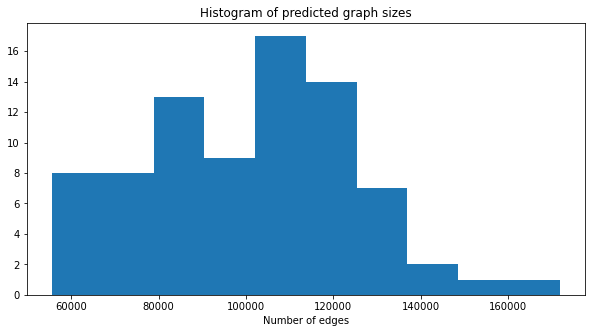

In [26]:
# Make histogram of graph sizes
plt.figure(figsize=(10,5))
plt.hist(graph_sizes);
plt.title('Histogram of predicted graph sizes');
plt.xlabel('Number of edges');

# 2. Construct graphs from metric learning inference

This step performs model inference on the entire input datasets (train, validation and test), to obtain input graphs to the graph neural network.

In [27]:
graph_builder = run_metric_learning_inference(CONFIG)

INFO:------------ Step 2: Constructing graphs from metric learning model  ------------
INFO:---------------------------- a) Loading trained model ----------------------------
INFO:----------------------------- b) Running inferencing -----------------------------
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021000
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021001
INFO:Loaded event: /global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021002


Training finished, running inference to build graphs...


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


# 3. Train graph neural networks

In [28]:
gnn_trainer, gnn_model = train_gnn(CONFIG)

INFO:-------------------------  Step 3: Running GNN training  -------------------------
INFO:----------------------------- a) Initialising model -----------------------------
INFO:------------------------------ b) Running training ------------------------------
INFO:GPU available: True, used: True
INFO:TPU available: False, using: 0 TPU cores
INFO:IPU available: False, using: 0 IPUs
INFO:HPU available: False, using: 0 HPUs
INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:
  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 35.1 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_edge_classifier | Sequential | 83.2 K
------------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.401     Total estimated model par

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old 

Epoch 0:   0%|          | 0/90 [00:00<?, ?it/s] 

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Epoch 0:  91%|█████████ | 82/90 [00:16<00:01,  4.98it/s, loss=0.794, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 0:  94%|█████████▍| 85/90 [00:16<00:00,  5.09it/s, loss=0.794, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 0:  99%|█████████▉| 89/90 [00:17<00:00,  5.23it/s, loss=0.794, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 1:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.794, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 1:  91%|█████████ | 82/90 [00:16<00:01,  4.85it/s, loss=0.72, v_num=0] 

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 1:  94%|█████████▍| 85/90 [00:17<00:01,  4.95it/s, loss=0.72, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 1:  99%|█████████▉| 89/90 [00:17<00:00,  5.10it/s, loss=0.72, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 2:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.72, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 2:  91%|█████████ | 82/90 [00:16<00:01,  4.89it/s, loss=0.626, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 2:  94%|█████████▍| 85/90 [00:17<00:01,  5.00it/s, loss=0.626, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Validation DataLoader 0:  90%|█████████ | 9/10 [00:00<00:00, 13.48it/s]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 3:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.626, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Validation DataLoader 0:  20%|██        | 2/10 [00:00<00:00,  9.69it/s]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 3:  93%|█████████▎| 84/90 [00:17<00:01,  4.93it/s, loss=0.551, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 3:  97%|█████████▋| 87/90 [00:17<00:00,  5.02it/s, loss=0.551, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 4:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.551, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 4:  91%|█████████ | 82/90 [00:17<00:01,  4.72it/s, loss=0.503, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 4:  94%|█████████▍| 85/90 [00:17<00:01,  4.83it/s, loss=0.503, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 4:  99%|█████████▉| 89/90 [00:17<00:00,  4.98it/s, loss=0.503, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_

Epoch 5:  91%|█████████ | 82/90 [00:16<00:01,  4.86it/s, loss=0.388, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 5:  94%|█████████▍| 85/90 [00:17<00:01,  4.98it/s, loss=0.388, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 5:  99%|█████████▉| 89/90 [00:17<00:00,  5.12it/s, loss=0.388, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_

Epoch 6:  91%|█████████ | 82/90 [00:16<00:01,  4.85it/s, loss=0.367, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 6:  94%|█████████▍| 85/90 [00:17<00:01,  4.95it/s, loss=0.367, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 6:  99%|█████████▉| 89/90 [00:17<00:00,  5.11it/s, loss=0.367, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 7:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.367, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 7:  91%|█████████ | 82/90 [00:17<00:01,  4.81it/s, loss=0.327, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 7:  94%|█████████▍| 85/90 [00:17<00:01,  4.92it/s, loss=0.327, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 7:  99%|█████████▉| 89/90 [00:17<00:00,  5.07it/s, loss=0.327, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 8:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.327, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 8:  91%|█████████ | 82/90 [00:17<00:01,  4.76it/s, loss=0.316, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 8:  94%|█████████▍| 85/90 [00:17<00:01,  4.86it/s, loss=0.316, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 8:  98%|█████████▊| 88/90 [00:17<00:00,  4.97it/s, loss=0.316, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 9:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.316, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 9:  91%|█████████ | 82/90 [00:17<00:01,  4.82it/s, loss=0.322, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 9:  94%|█████████▍| 85/90 [00:17<00:01,  4.92it/s, loss=0.322, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 9:  98%|█████████▊| 88/90 [00:17<00:00,  5.03it/s, loss=0.322, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_

Epoch 10:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.322, v_num=0]        

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 10:  91%|█████████ | 82/90 [00:16<00:01,  4.89it/s, loss=0.24, v_num=0] 

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 10:  93%|█████████▎| 84/90 [00:16<00:01,  4.96it/s, loss=0.24, v_num=0]


/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 10:  98%|█████████▊| 88/90 [00:17<00:00,  5.10it/s, loss=0.24, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_

Epoch 11:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.24, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 11:  91%|█████████ | 82/90 [00:17<00:01,  4.80it/s, loss=0.222, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 11:  93%|█████████▎| 84/90 [00:17<00:01,  4.88it/s, loss=0.222, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 11:  97%|█████████▋| 87/90 [00:17<00:00,  4.97it/s, loss=0.222, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 12:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.222, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 12:  91%|█████████ | 82/90 [00:17<00:01,  4.79it/s, loss=0.188, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 12:  94%|█████████▍| 85/90 [00:17<00:01,  4.90it/s, loss=0.188, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 12:  98%|█████████▊| 88/90 [00:17<00:00,  5.01it/s, loss=0.188, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 13:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.188, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 13:  91%|█████████ | 82/90 [00:17<00:01,  4.81it/s, loss=0.169, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 13:  94%|█████████▍| 85/90 [00:17<00:01,  4.91it/s, loss=0.169, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 13:  98%|█████████▊| 88/90 [00:17<00:00,  5.02it/s, loss=0.169, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_

Epoch 14:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.169, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 14:  91%|█████████ | 82/90 [00:16<00:01,  4.84it/s, loss=0.165, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 14:  94%|█████████▍| 85/90 [00:17<00:01,  4.95it/s, loss=0.165, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 14:  99%|█████████▉| 89/90 [00:17<00:00,  5.10it/s, loss=0.165, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_

Epoch 15:  91%|█████████ | 82/90 [00:16<00:01,  4.90it/s, loss=0.214, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 15:  94%|█████████▍| 85/90 [00:16<00:00,  5.01it/s, loss=0.214, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 15:  98%|█████████▊| 88/90 [00:17<00:00,  5.13it/s, loss=0.214, v_num=0]


/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 16:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.214, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Validation DataLoader 0:  30%|███       | 3/10 [00:00<00:00, 14.50it/s]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 16:  94%|█████████▍| 85/90 [00:17<00:01,  4.93it/s, loss=0.155, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 16:  99%|█████████▉| 89/90 [00:17<00:00,  5.07it/s, loss=0.155, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 17:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.155, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 17:  91%|█████████ | 82/90 [00:17<00:01,  4.82it/s, loss=0.141, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 17:  94%|█████████▍| 85/90 [00:17<00:01,  4.92it/s, loss=0.141, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 17:  97%|█████████▋| 87/90 [00:17<00:00,  4.98it/s, loss=0.141, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 18:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.141, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 18:  90%|█████████ | 81/90 [00:16<00:01,  4.80it/s, loss=0.128, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 18:  93%|█████████▎| 84/90 [00:17<00:01,  4.91it/s, loss=0.128, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 18:  97%|█████████▋| 87/90 [00:17<00:00,  5.01it/s, loss=0.128, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 19:   0%|          | 0/90 [00:00<?, ?it/s, loss=0.128, v_num=0]         

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 19:  91%|█████████ | 82/90 [00:17<00:01,  4.77it/s, loss=0.121, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 19:  94%|█████████▍| 85/90 [00:17<00:01,  4.87it/s, loss=0.121, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Epoch 19:  99%|█████████▉| 89/90 [00:17<00:00,  5.03it/s, loss=0.121, v_num=0]

/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/trackml-quickstart/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_

Epoch 19: 100%|██████████| 90/90 [00:17<00:00,  5.05it/s, loss=0.121, v_num=0]


INFO:-------------------------------- c) Saving model --------------------------------


## Plot training metrics

In [31]:
log_file = os.path.join(gnn_trainer.logger.log_dir , 'metrics.csv')
metrics = pd.read_csv(log_file, sep=',')
train_metrics = metrics[ ~ metrics['train_loss'].isna() ][['epoch', 'train_loss']]
train_metrics['epoch'] -= 1
val_metrics = metrics[ ~ metrics['val_loss'].isna() ][['val_loss', 'eff', 'pur', 'current_lr', 'epoch']]
metrics = pd.merge(left=train_metrics, right=val_metrics, how='inner', on='epoch')
metrics.head()

,epoch,train_loss,val_loss,eff,pur,current_lr
0,0,0.762294,0.793950,0.634478,0.525223,0.0002
1,1,0.666753,0.709571,0.688242,0.580861,0.0004
2,2,0.589926,0.643226,0.587222,0.755789,0.0006
3,3,0.515559,0.534713,0.755348,0.712547,0.0008
4,4,0.426854,0.468520,0.812216,0.738502,0.0010


In [32]:
p1 = figure(title='Training validation loss', x_axis_label='Epoch', y_axis_label='Loss', y_axis_type="log")

source = ColumnDataSource(metrics)

cmap = viridis(3)

for idx, y in enumerate(['train_loss', 'val_loss']):
    p1.circle(y=y, x='epoch', source=source, color=cmap[idx], legend_label=y)
    p1.line(x='epoch', y=y, source=source, color=cmap[idx], legend_label=y)


p2 = figure(title='Purity on validation set', x_axis_label='Epoch', y_axis_label='Purity')
p2.circle(y='pur', x='epoch', source=source, color=cmap[0], legend_label='Purity')
p2.line(x='epoch', y='pur', source=source, color=cmap[0], legend_label='Purity')

p3 = figure(title='Efficiency on validation set', x_axis_label='Epoch', y_axis_label='Efficiency')
p3.circle(y='eff', x='epoch', source=source, color=cmap[0], legend_label='Efficiency')
p3.line(x='epoch', y='eff', source=source, color=cmap[0], legend_label='Efficiency')

show(row([p1,p2, p3]))

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [44]:
all_efficiencies, all_purities, all_losses = [], [], []
all_cuts = np.arange(0.001, 1., 0.02)
results = { 'eff': [], 'pur': [], 'score cut': all_cuts }
gnn_model.to(device)
test_data = gnn_model.testset[0].to(device)

with torch.no_grad():
    test_results = gnn_model.shared_evaluation(
            test_data, 0, log=False
        )
    
    for cut in all_cuts:
        preds = test_results["score"] > cut
        edge_positive = preds.sum().float()
        edge_true = test_results["truth"].sum().float()
        edge_true_positive = (
            (test_results["truth"].bool() & preds).sum().float()
        )
        # Calculate roc curve
        

        results["eff"].append( (edge_true_positive / max(1, edge_true)).cpu().numpy() )
        results["pur"].append( (edge_true_positive / max(1, edge_positive)).cpu().numpy() )
results = pd.DataFrame(results)

source = ColumnDataSource(results)
cmap = viridis(3)
titles = ['Efficiency', 'Purity'] 
figures = []
x='score cut'
for idx, y in enumerate(['eff', 'pur']):
    figures.append( figure(title=titles[idx], x_axis_label=x, y_axis_label=y) )
    figures[-1].circle(y=y, x=x, source=source, color=cmap[0], legend_label=y)
    figures[-1].line(x=x, y=y, source=source, color=cmap[0], legend_label=y)
    y_val = results[y][(results[x] - 0.5).abs().idxmin()].item()
    label = Label(x=0.1, y=y_val, x_offset=10, y_offset=-10, text="@ score cut = 0.5, \n" + y + " = "+str(round(y_val, 3)), border_line_color='black', border_line_alpha=1.0,
      background_fill_color='white', background_fill_alpha=0.8)
    figures[-1].add_layout(label)

show(row(figures))

# Step 4: GNN inference 

In [45]:
run_gnn_inference(CONFIG)

INFO:--------------------- Step 4: Scoring graph edges using GNN  ---------------------
INFO:---------------------------- a) Loading trained model ----------------------------
INFO:----------------------------- b) Running inferencing -----------------------------


Training finished, running inference to filter graphs...
Building train


100%|██████████| 80/80 [00:03<00:00, 24.75it/s]


Building val


100%|██████████| 10/10 [00:00<00:00, 23.47it/s]


Building test


100%|██████████| 10/10 [00:00<00:00, 23.12it/s]


# Step 5: Build track candidates from GNN

In [3]:
from Pipelines.TrackML_Example.LightningModules.GNN.Models.interaction_gnn import InteractionGNN
common_configs = configs["common_configs"]
gnn_model = InteractionGNN.load_from_checkpoint(os.path.join(common_configs["artifact_directory"], "gnn", common_configs["experiment_name"]+".ckpt")).to(device)
gnn_model.setup(stage="fit")

In [4]:
build_track_candidates(CONFIG)

INFO:-----------  Step 5: Building track candidates from the scored graph  -----------
INFO:---------------------------- a) Loading scored graphs ----------------------------
INFO:---------------------------- b) Labelling graph nodes ----------------------------
100%|██████████| 100/100 [00:01<00:00, 50.32it/s]


# Step 6: Evaluate track candidates

We can control the matching style in the pipeline config file. The following all require at least a majority of hits to match in each scheme (i.e. matching fraction = 50%)

ATLAS style matching is the default.

In [50]:
evaluate_candidates(CONFIG)

INFO:------------ Step 6: Evaluating the track reconstruction performance ------------
INFO:--------------------------- a) Loading labelled graphs ---------------------------
100%|██████████| 100/100 [00:01<00:00, 54.59it/s]
INFO:---------------------------- b) Plotting the results ----------------------------
INFO:Efficiency: 0.981
INFO:Fake rate: 0.055
INFO:Duplication rate: 0.258


One-way matching is another approach:

In [48]:
evaluate_candidates(CONFIG)

INFO:------------ Step 6: Evaluating the track reconstruction performance ------------
INFO:--------------------------- a) Loading labelled graphs ---------------------------
100%|██████████| 100/100 [00:01<00:00, 55.04it/s]
INFO:---------------------------- b) Plotting the results ----------------------------
INFO:Efficiency: 0.731
INFO:Fake rate: 0.017
INFO:Duplication rate: 0.000


Two-way matching is the most strict approach

In [47]:
evaluate_candidates(CONFIG)

INFO:------------ Step 6: Evaluating the track reconstruction performance ------------
INFO:--------------------------- a) Loading labelled graphs ---------------------------
100%|██████████| 100/100 [00:01<00:00, 65.44it/s]
INFO:---------------------------- b) Plotting the results ----------------------------
INFO:Efficiency: 0.714
INFO:Fake rate: 0.700
INFO:Duplication rate: 0.000
